<a href="https://colab.research.google.com/github/juliediumina/AI-240/blob/main/stage_duration_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Agile Stage Duration Prediction using Machine Learning

Final Project — ML 110
Student: Iuliia Diumina
Algorithms Used: Random Forest Regression, Linear Regression

Project Descriptio

In Agile software development, one of the biggest challenges teams face is predicting how long a task will remain in each workflow stage (e.g., Backlog, In Progress, In Review, Testing).
Inaccurate time predictions lead to poor sprint planning, delays, and inefficient resource allocation.
This project builds a machine learning model that predicts how many days a task will stay in its current stage (days_in_stage).
The dataset includes features such as:
issue type
story points
priority
team
dependencies
number of previous stages
current Agile stage

Using these features, the model estimates the expected duration of the stage.
The goal of this project is to:

Explore the data using descriptive statistics and visualizations

Preprocess the dataset (cleaning, encoding categorical variables, handling missing values)

Train machine learning models (Random Forest and Linear Regression)

Evaluate and compare the models using metrics such as MAE, RMSE, and R²

Determine which algorithm performs best for predicting Agile cycle time



This type of prediction is valuable for real-world product teams because it can help improve sprint planning, identify bottlenecks, prioritize work more effectively, and support better decision-making in Agile environments.

Target Variable
days_in_stage — number of days the task remains in its current workflow stage.

Feature Variables
Examples include:
issue_type
story_points
priority
team
num_dependencies
previous_stages_count
current_stage

Import Libraries

In [ ]:
#Import all necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

print("Google Drive mounted successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!


In [ ]:
#Loading dataset
df = pd.read_csv("/content/drive/My Drive/ML/agile_stage_time_synthetic_1000.csv")

#preview dara
df.head()

,task_id,issue_type,story_points,priority,team,current_stage,previous_stages_count,num_dependencies,entered_stage_date,next_stage_date,days_in_stage
0,T-0001,Feature,2,Medium,Team B,In Progress,2,1,2024-04-25,2024-05-03,7.80
1,T-0002,Spike,3,Medium,Team C,In Review,3,2,2024-02-20,2024-02-24,3.88
2,T-0003,Task,8,High,Team A,In Review,2,2,2024-06-29,2024-07-01,2.48
3,T-0004,Bug,5,Medium,Team B,Backlog,3,4,2024-01-04,2024-01-11,6.66
4,T-0005,Feature,8,Medium,Team B,Backlog,3,4,2024-03-19,2024-03-31,11.60


Data Exploration


I will start inspecting the dataset, understanding the structure of the data, identifying key features, and reviewing the distribution of the target variable (days_in_stage).
I will also visualize relationships between features using Seaborn/Matplotlib.

In [ ]:
#Basic dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   task_id                1000 non-null   object 
 1   issue_type             1000 non-null   object 
 2   story_points           1000 non-null   int64  
 3   priority               1000 non-null   object 
 4   team                   1000 non-null   object 
 5   current_stage          1000 non-null   object 
 6   previous_stages_count  1000 non-null   int64  
 7   num_dependencies       1000 non-null   int64  
 8   entered_stage_date     1000 non-null   object 
 9   next_stage_date        1000 non-null   object 
 10  days_in_stage          1000 non-null   float64
dtypes: float64(1), int64(3), object(7)
memory usage: 86.1+ KB


The df.info() results confirm 1000 rows, 11 columns, no missing values, and show the data types for each feature.

In [ ]:
# Statistical summary of numeric columns
df.describe()

,story_points,previous_stages_count,num_dependencies,days_in_stage
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.270000,1.497000,2.438000,6.163080
std,3.104309,1.120378,1.701485,2.653589
min,1.000000,0.000000,0.000000,0.500000
25%,2.000000,1.000000,1.000000,4.380000
50%,3.000000,1.000000,2.000000,5.695000
75%,5.000000,3.000000,4.000000,7.580000
max,13.000000,3.000000,5.000000,19.300000


The summary highlights typical task characteristics: around 4 story points, 2–3 dependencies, and about 6 days spent per stage

In [ ]:
# Check for missing values
df.isnull().sum()

,0
task_id,0
issue_type,0
story_points,0
priority,0
team,0
current_stage,0
previous_stages_count,0
num_dependencies,0
entered_stage_date,0
next_stage_date,0


No missing values

Categorical feature distributions


In [ ]:
# Display value counts for categorical features
df['issue_type'].value_counts()
df['priority'].value_counts()
df['team'].value_counts()
df['current_stage'].value_counts()

,count
current_stage,
In Progress,460
Backlog,257
In Review,190
Testing,93


The dataset includes categorical features with uneven distributions, which will need encoding later for model training.

Plot Target Variable Distribution

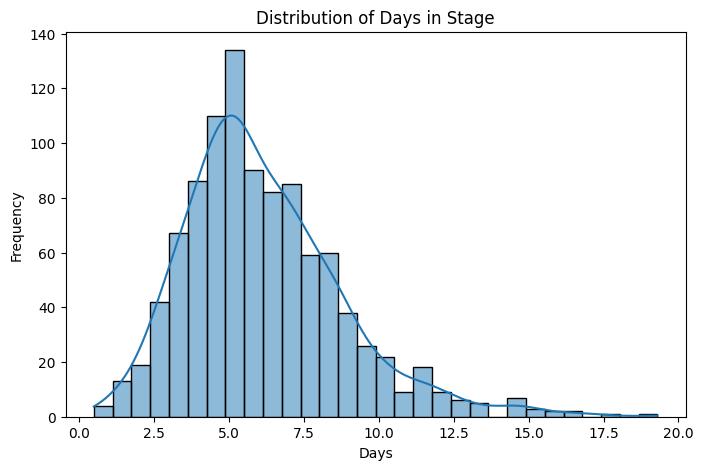

In [ ]:
# Set the figure size for better readability
plt.figure(figsize=(8,5))
# Create a histogram of 'days_in_stage' with a Kernel Density Estimate (KDE) overlay
sns.histplot(df['days_in_stage'], kde=True, bins=30)
# Set the title of the plot
plt.title("Distribution of Days in Stage")
# Label the x-axis
plt.xlabel("Days")
# Label the y-axis
plt.ylabel("Frequency")
# Display the plot
plt.show()

Interpretation of the Distribution
The distribution of days_in_stage shows a strong peak around 5 days, which aligns with a typical Agile workweek.
This suggests that most tasks progress through this stage within one week.
Tasks that exceed 5–7 days become potential risk indicators, meaning they may be:
blocked,
waiting on dependencies,
under-estimated, or
lower priority.
This pattern supports the need for a predictive model:
If we can forecast tasks likely to exceed the typical 5-day window, teams can prioritize them earlier and prevent delays.

Correlation Heatmap (numeric only)

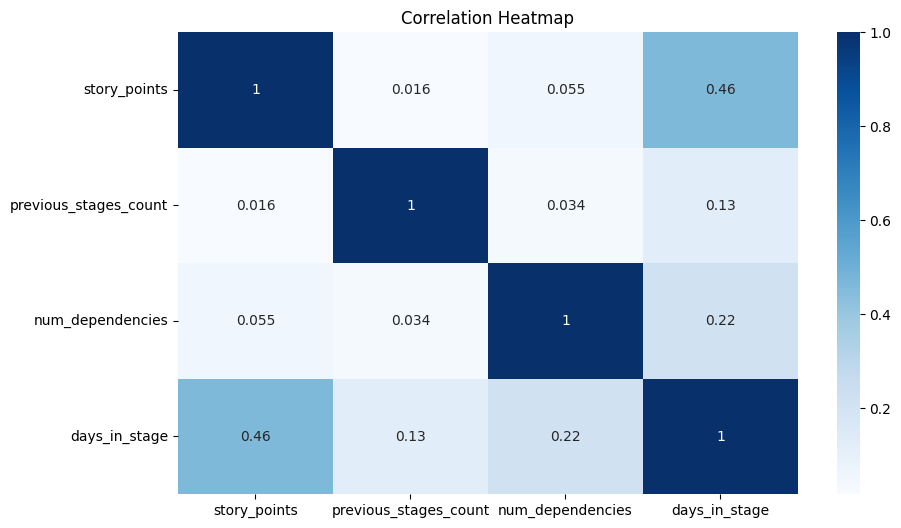

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="Blues")
plt.title("Correlation Heatmap")
plt.show()


Correlation Analysis
The correlation heatmap shows how strongly each numerical feature is related to the target variable days_in_stage.
The strongest relationship is between:
story_points and days_in_stage (0.46) — a moderate positive correlation, meaning tasks with more story points tend to stay longer in a stage.
This aligns with Agile project behavior, where higher-complexity tasks require more time.
Other features (previous_stages_count, num_dependencies) show weaker correlations.
This suggests that the relationship between these variables and the target may be non-linear, which justifies using machine learning models such as Random Forest Regression, which can capture more complex interactions.


Boxplot: Story Points vs Duration

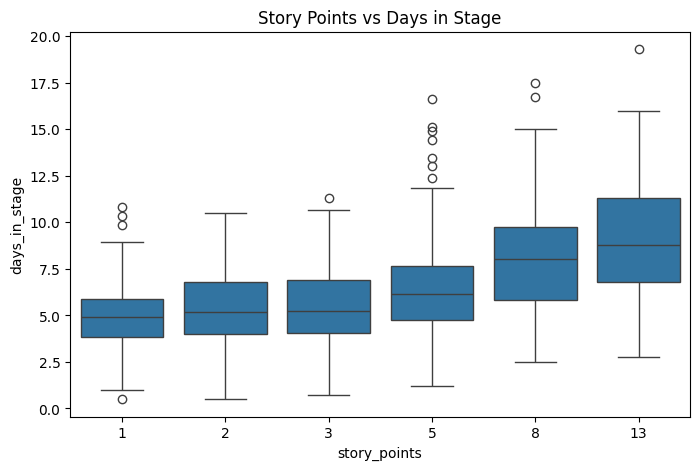

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='story_points', y='days_in_stage')
plt.title("Story Points vs Days in Stage")
plt.show()


Higher story point tasks tend to stay longer in the stage, showing a positive relationship between complexity and duration

Boxplot: Priority vs Duration

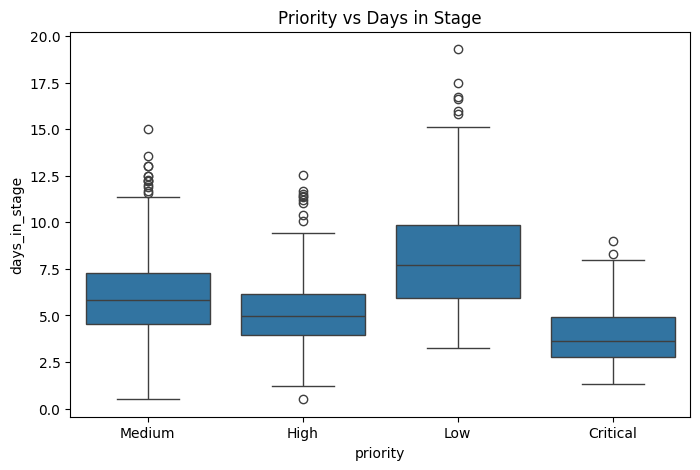

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='priority', y='days_in_stage')
plt.title("Priority vs Days in Stage")
plt.show()


Critical and High priority tasks move faster, while Low priority tasks remain in the stage longer

Data Preprocessing

In [11]:
# === Select features and target ===
X = df.drop(columns=['days_in_stage', 'task_id', 'entered_stage_date', 'next_stage_date'])
y = df['days_in_stage']

# Identify categorical and numeric columns
categorical_features = ['issue_type', 'priority', 'team', 'current_stage']
numeric_features = ['story_points', 'previous_stages_count', 'num_dependencies']

# === Preprocessing for categorical variables ===
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

Train/Test Split

In [12]:
#Split into training and testing datasets ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Model Building (Two Algorithms)

Model 1: Linear Regression

In [13]:
#Linear Regression Model Pipeline ===
lr_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

# Train model
lr_model.fit(X_train, y_train)

# Predict
lr_preds = lr_model.predict(X_test)

Model 2: Random Forest Regressor

In [14]:
# === Random Forest Model Pipeline ===
rf_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42))
])

# Train model
rf_model.fit(X_train, y_train)

# Predict
rf_preds = rf_model.predict(X_test)


Model Evaluation & Comparison

In [15]:
def evaluate_model(true, preds, model_name):
    mae = mean_absolute_error(true, preds)
    rmse = np.sqrt(mean_squared_error(true, preds))
    r2 = r2_score(true, preds)

    print(f"---- {model_name} ----")
    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²:   {r2:.3f}")
    print()


Evaluate Linear Regression

In [16]:
evaluate_model(y_test, lr_preds, "Linear Regression")

---- Linear Regression ----
MAE:  0.856
RMSE: 1.071
R²:   0.819



Evaluate Random Forest

In [ ]:
evaluate_model(y_test, rf_preds, "Random Forest Regressor")


---- Random Forest Regressor ----
MAE:  0.860
RMSE: 1.078
R²:   0.816



Feature Importance (Random Forest Only)

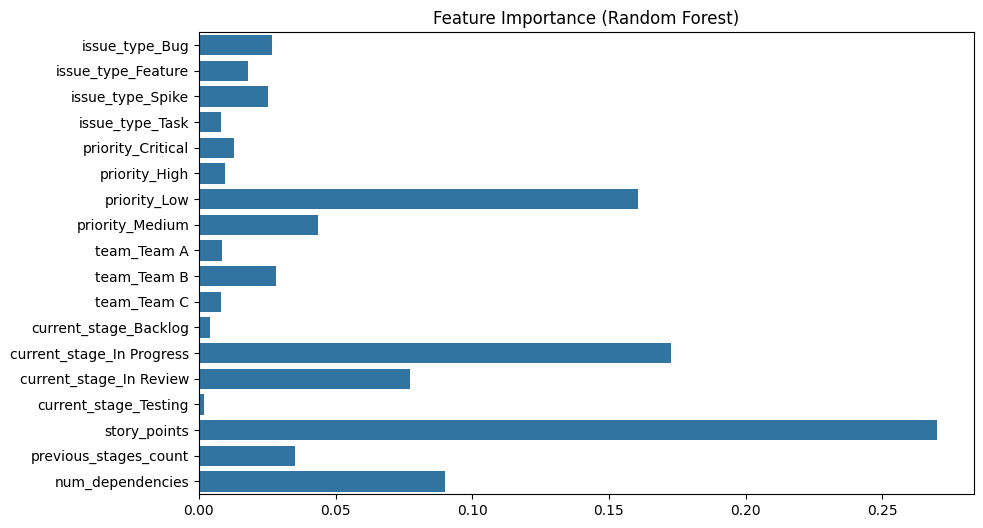

In [ ]:
# === Extract feature names after one-hot encoding ===
ohe = rf_model.named_steps['preprocess'].named_transformers_['cat']
ohe_features = list(ohe.get_feature_names_out(categorical_features))
all_features = ohe_features + numeric_features

# === Feature Importance Plot ===
importances = rf_model.named_steps['model'].feature_importances_

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=all_features)
plt.title("Feature Importance (Random Forest)")
plt.show()

In [ ]:
import joblib
joblib.dump(rf_model, "stage_duration_model.joblib")


['stage_duration_model.joblib']

In [ ]:
from google.colab import files
files.download("stage_duration_model.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>